# Background blurring

Semantic segmentation applied to video camera background blurring, refer to: https://github.com/tensorflow/models/tree/master/research/deeplab

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import cv2

import tflite_runtime.interpreter as tflite

MODEL = '../models/deeplabv3_mnv2_dm05_pascal_quant_edgetpu.tflite'
#MODEL = '../models/deeplabv3_mnv2_pascal_quant_edgetpu.tflite'

In [27]:
def build_model(model_path=MODEL):
    """
    Forms the tensorflow lite model and configures the coral device.
    """
    interpreter = tflite.Interpreter(
        model_path=model_path,
        experimental_delegates=[tflite.load_delegate("libedgetpu.so.1")],
    )

    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    height = input_details[0]["shape"][1]
    width = input_details[0]["shape"][2]

    dims = (width, height)
    return interpreter, input_details, output_details, dims


def process_frame(frame, interpreter, input_details, output_details, dims):
    """
    Use the CORAl edge TPU to process a frame. 
    """
    input_data = np.expand_dims(cv2.resize(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), dims), axis=0)
   
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index'])
    
    mask = np.squeeze(output_data)   
    
    return np.where(mask==15, 255, 0)


def masked_frame(frame, mask, filter_size=(31, 31)):
    """
    Use OpenCV to apply a background blur.
    """
    
    #resize the mask
    mask = cv2.resize(mask.astype(np.uint8), (frame.shape[1], frame.shape[0]), interpolation=cv2.INTER_NEAREST)
    mask = mask.repeat(3).reshape(mask.shape[0], mask.shape[1], 3)
  
    foreground = np.where(mask, frame, 0).astype(float)
    
    background = cv2.cvtColor(cv2.GaussianBlur(frame, filter_size, 0), cv2.COLOR_BGR2GRAY)
    background = cv2.cvtColor(background, cv2.COLOR_GRAY2RGB).astype(float)

    alpha = cv2.GaussianBlur(mask, filter_size, 0)
    alpha = alpha.astype(float) / 255.
      
    blended = cv2.convertScaleAbs(background*(1-alpha) + foreground*(1.5*alpha))
        
    return blended


In [28]:
model_params = build_model() 
capture = cv2.VideoCapture(0)

while True:
    ret, frame = capture.read()
    mask = process_frame(frame, *model_params)
    composite = masked_frame(frame, mask)
    cv2.imshow("video", composite)
    
    if cv2.waitKey(1) == 27:
        break

capture.release()
cv2.destroyAllWindows()

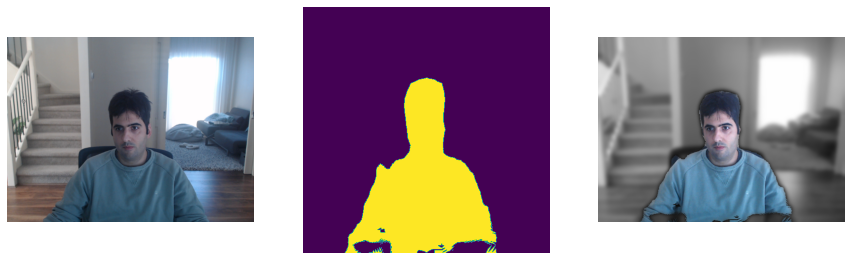

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5) )
ax1.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)); ax1.axis('off')
ax2.imshow(mask); ax2.axis('off')
ax3.imshow(cv2.cvtColor(composite, cv2.COLOR_BGR2RGB));  ax3.axis('off');